# ACS2 vs ACS2ER in Multiplexer

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics

import gym
import gym_multiplexer
from gym_multiplexer.utils import get_correct_answer
from lcs import Perception

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER


# EXPERIMENT CONFIGURATION

In [2]:
RUN = 10

EXPERIMENTS = 1

BITS = 11 # 6 | 11 | 20 | 37

EXPLORE_TRIALS = 1000
EXPLOIT_TRIALS = 100

# The size of ER replay memory buffer
ER_BUFFER_SIZE=250
# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=25
# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3


## Metrics and helpers

In [3]:
import itertools

def mpx_knowledge(population, environment) -> float:
    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    if(len(reliable_classifiers) == 0):
        return 0

    states = list(itertools.product([0, 1], repeat=BITS))
    states_len = len(states)

    nr_correct = 0

    for state in states:
        p0 = [str(float(x)) for x in state] + ['0.0']   # initial state
        p1 = [str(float(x)) for x in state] + ['1.0']  # cast to strings
        correct_answer = get_correct_answer(list(state) + [0], environment.env.env.control_bits)  # true action

        if any([True for cl in reliable_classifiers if
                cl.predicts_successfully(
                    Perception(p0),
                    correct_answer,
                    Perception(p1))]):

            nr_correct += 1

    return nr_correct / states_len


def mpx_metrics(agent, env):
    metrics = {
        "knowledge": mpx_knowledge(agent.population, env)
    }
    metrics.update(population_metrics(agent.population, env))

    return metrics


class MpxObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return [str(x) for x in observation]

### Results arrays

ACS2 Experiments

In [4]:
for e in range(EXPERIMENTS):
    ### ACS2 ###
    # Load desired environment
    mp = MpxObservationWrapper(gym.make(F'boolean-multiplexer-{BITS}bit-v0'))
    # Create agent 
    cfg_acs2 = CFG_ACS2(classifier_length=mp.env.observation_space.n,
                        number_of_possible_actions=2,
                        do_ga=True,
                        metrics_trial_frequency=10,
                        user_metrics_collector_fcn=mpx_metrics)
    agent_acs2 = ACS2(cfg_acs2)
    # Explore the environment
    acs2_explore_metrics = agent_acs2.explore(mp, EXPLORE_TRIALS)
    # Exploit the environment
    acs2_exploit_metrics = agent_acs2.exploit(mp, EXPLOIT_TRIALS)


ACS2ER Experiments

In [5]:
for e in range(EXPERIMENTS):
    ### ACS2ER ###
    # Load desired environment
    mp = MpxObservationWrapper(gym.make(F'boolean-multiplexer-{BITS}bit-v0'))
    # Create agent ACS2ER
    cfg_acs2er = CFG_ACS2ER(classifier_length=mp.env.observation_space.n,
                        number_of_possible_actions=2,
                        do_ga=True,
                        metrics_trial_frequency=10,
                        er_buffer_size=ER_BUFFER_SIZE,
                        er_min_samples=ER_BUFFER_MIN_SAMPLES,
                        er_samples_number=ER_SAMPLES_NUMBER,
                        user_metrics_collector_fcn=mpx_metrics)
    agent_acs2er = ACS2ER(cfg_acs2er)
    # Explore the environment
    acs2er_explore_metrics = agent_acs2er.explore(mp, EXPLORE_TRIALS)
    # Exploit the environment
    acs2er_exploit_metrics = agent_acs2er.exploit(mp, EXPLOIT_TRIALS)

    

In [6]:
RELIABLE_KEY = "reliable"
KNOWLEDGE_KEY = "knowledge"

def extract_number_of_reliable_cl(metrics):
    return list(map(lambda m: m[RELIABLE_KEY], metrics))

def extract_knowledge(metrics):
    return list(map(lambda m: m[KNOWLEDGE_KEY], metrics))

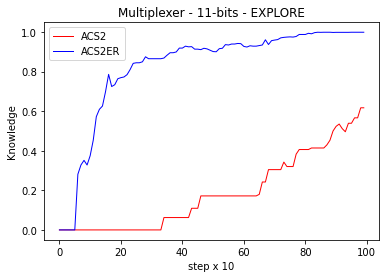

In [7]:
acs2_knowledge = extract_knowledge(acs2_explore_metrics)
acs2er_knowledge = extract_knowledge(acs2er_explore_metrics)

x_axis = range(len(acs2_knowledge))

plt.title(f"Multiplexer - {BITS}-bits - EXPLORE")
plt.plot(x_axis, acs2_knowledge, c='r', label="ACS2", linewidth=1.0)
plt.plot(x_axis, acs2er_knowledge, c='b', label="ACS2ER", linewidth=1.0)
plt.legend()
plt.xlabel("step x 10")
plt.ylabel("Knowledge")
plt.show()
# plt.savefig(f"EXPLORE_KNOWLEDGE_{RUN}.png")

